In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

In [3]:
IMAGE_SIZE = [176, 208]

# Data Loading

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory("./Alzheimer_s Dataset/train", validation_split=0.2, seed=1818,
    image_size=IMAGE_SIZE, subset="training", batch_size=64)

val_ds = tf.keras.preprocessing.image_dataset_from_directory("./Alzheimer_s Dataset/train", validation_split=0.2, seed=1818,
    image_size=IMAGE_SIZE, subset="validation", batch_size=64)

Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 5121 files belonging to 4 classes.
Using 1024 files for validation.


In [5]:
class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
train_ds.class_names = class_names
val_ds.class_names = class_names
NUM_CLASSES = len(class_names)

# Visualizing Data

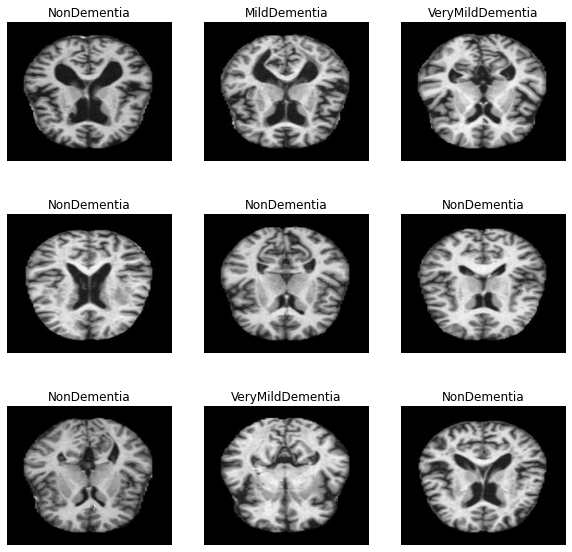

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

# Feature Engineering

In [7]:
def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_ds = train_ds.map(one_hot_label)
val_ds = val_ds.map(one_hot_label)

In [8]:
NUM_IMAGES = []

for label in class_names:
    dir_name = "./Alzheimer_s Dataset/train/" + label[:-2] + 'ed'
    NUM_IMAGES.append(len([name for name in os.listdir(dir_name)]))

In [9]:
NUM_IMAGES

[717, 52, 2560, 1792]

# Neural Network

In [10]:
init = tf.keras.initializers.GlorotUniform()
model = tf.keras.Sequential([
    tf.keras.Input(shape=(*IMAGE_SIZE, 3)),
    tf.keras.layers.Conv2D(16, (3, 3), kernel_initializer='he_uniform', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer='he_uniform', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, kernel_initializer='he_uniform', activation='relu'),
    tf.keras.layers.Dense(64, kernel_initializer='he_uniform', activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, kernel_initializer=init, activation='softmax')
])

# Compiling Model

Area Under the Curve (AUC) of Receiver Characteristic Operator
The Receiver Operator Characteristic (ROC) curve is an evaluation metric classification problems.
It is a probability curve that plots the TPR against FPR at various threshold values.
The Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between classes.

In [11]:
rocauc = [tf.keras.metrics.AUC(name='auc')]
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=rocauc)

# Training Model

In [12]:
history = model.fit(train_ds, validation_data=val_ds, epochs=50, shuffle=True, verbose=1)

Epoch 1/50
65/65 [==============================] - 108s 2s/step - loss: 310.3829 - auc: 0.6804 - val_loss: 4.0786 - val_auc: 0.7965
Epoch 2/50
65/65 [==============================] - 85s 1s/step - loss: 1.2861 - auc: 0.9064 - val_loss: 0.6653 - val_auc: 0.9531
Epoch 3/50
65/65 [==============================] - 114s 2s/step - loss: 0.4625 - auc: 0.9702 - val_loss: 0.8260 - val_auc: 0.9454
Epoch 4/50
65/65 [==============================] - 88s 1s/step - loss: 0.2152 - auc: 0.9901 - val_loss: 0.4599 - val_auc: 0.9695
Epoch 5/50
65/65 [==============================] - 77s 1s/step - loss: 0.0697 - auc: 0.9988 - val_loss: 0.3890 - val_auc: 0.9780
Epoch 6/50
65/65 [==============================] - 77s 1s/step - loss: 0.0432 - auc: 0.9996 - val_loss: 0.1934 - val_auc: 0.9927
Epoch 7/50
65/65 [==============================] - 70s 1s/step - loss: 0.0223 - auc: 0.9998 - val_loss: 0.1641 - val_auc: 0.9950
Epoch 8/50
65/65 [==============================] - 81s 1s/step - loss: 0.0094 - auc: 

In [13]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory("./Alzheimer_s Dataset/test", image_size=IMAGE_SIZE,
batch_size=64)

test_ds = test_ds.map(one_hot_label)

Found 1279 files belonging to 4 classes.


In [15]:
res = model.evaluate(test_ds)

20/20 [==============================] - 8s 423ms/step - loss: 3.4473 - auc: 0.7764


In [105]:
res = model.evaluate(test_ds)

80/80 [==============================] - 7s 93ms/step - loss: 3.3802 - auc: 0.8376: 2s - los
